In [2]:
import numpy as np
import pandas as pd
import random

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

## Read in data

In [4]:
susyDataset = "path/to/SUSYnormalized.csv"
df=pd.read_csv(susyDataset, sep=',',header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1.0,0.971370,0.063970,-1.223079,-0.754071,-0.337943,1.669839,2.835978,-1.217158,-1.110447,3.769216,0.072541,-0.739418,-1.100135,-1.164297,-0.888814,-1.274252,0.739308,0.775052
1,1.0,-0.808163,-0.133904,-0.708738,-0.837198,-1.609266,-0.767390,0.251972,0.503158,0.932196,-0.430650,-0.753885,-0.100052,1.248020,1.191606,-0.638962,0.901269,0.311788,-0.223392
2,1.0,-0.900671,-0.973143,0.692047,-0.841417,0.889265,-0.676206,1.183526,1.530473,2.297123,-1.003637,-0.685342,0.026117,1.236725,0.641831,-0.384872,1.146696,1.129964,-0.681261
3,1.0,0.450551,-0.687974,-0.675082,0.901611,-0.691327,0.621912,0.100342,-0.381147,-0.463096,1.363355,0.284546,-0.054335,-0.576317,-1.164297,0.133791,-1.533846,0.356272,-0.660245
4,-1.0,-0.791347,1.095944,1.509983,-0.378555,0.637195,-0.740988,-0.776014,1.318837,-0.934584,0.359417,-0.812766,-0.999443,-0.520532,-0.810791,-0.868423,-1.049513,-0.610517,-0.197329


In [82]:
Y = df.iloc[:,0].to_numpy()
X = df.iloc[:,1:].to_numpy()
print(X.shape, Y.shape)

paramFrac = 0.2
trainFrac = 0.4
testfrac = 0.2
globalfrac = 0.4

n = 5000
nTrain = 500#int(n*trainFrac)
nTest = 10000#int(n*testfrac)
nGlobal = 10000#int(n*globalfrac)
nParam = 1000#int(n*paramFrac)

Xglobal = X[nTrain + nTest:nTrain + nTest + nGlobal]
Yglobal = Y[nTrain + nTest:nTrain + nTest + nGlobal]
Xtest = X[nTrain:nTrain + nTest]
Ytest = Y[nTrain:nTrain + nTest]
Xparam = X[nTrain + nTest + nGlobal:nTrain + nTest + nGlobal + nParam]
Yparam = Y[nTrain + nTest + nGlobal:nTrain + nTest + nGlobal + nParam]
X = X[:nTrain]
Y = Y[:nTrain]

print(X.shape, Y.shape, Xglobal.shape, Yglobal.shape, Xtest.shape, Ytest.shape, Xparam.shape, Yparam.shape)

(3698112, 18) (3698112,)
(500, 18) (500,) (10000, 18) (10000,) (10000, 18) (10000,) (1000, 18) (1000,)


## Separate data into local datasets

Training data is separated by drawing half of each local dataset uniform at random and half of the dataset based on the value of one selected feature.

For the selected feature col (I have chosen feature 0 rather randomly, here), its values are binned by frequency (each bin contains an equal amount of data points) and each bin is appended to one local dataset. Thus, half of each local dataset is uniform, the other half has one particular feature value in a fixed range that is different from all other local datasets. Thus, there is some mild form on non-iid-ness in the distribution of X.

In [83]:
def equalFrequencyIntervals(vals, bins):
    n = len(vals)
    intervals = np.interp(np.linspace(0, n, bins + 1), np.arange(n), np.sort(vals))
    intervals[-1] += 0.00001 #this should solve rounding errors
    return intervals

def getLearner(i, intervals, X, col):
    for j in range(len(intervals)):
        if X[i,col] < intervals[j]:
            return j - 1
    print(X[i,col], intervals)

def distributeDataset(X, Y, col, num_learners, frac_colBin = 0.5):
    n = Y.shape[0]
    n_colBin = int(n*frac_colBin)
    
    
    indices = list(range(n))
    random.shuffle(indices)
    
    indColBin    = indices[:n_colBin]
    indNonColBin = indices[n_colBin:]
    
    Xs = np.array_split(X[indNonColBin,:], num_learners)    
    Ys = np.array_split(Y[indNonColBin], num_learners)    
    
    
    vals = X[indColBin,col]
    intervals = equalFrequencyIntervals(vals, num_learners)
    
    Idxs = [[] for _ in range(num_learners)]
    count = 0
    for i in indColBin:
        l = getLearner(i, intervals, X, col)
        Idxs[l].append(i)
        count += 1
        
        
    for l in range(num_learners):
        Xcolbin = X[Idxs[l],:]
        Ycolbin = Y[Idxs[l]]
        Xs[l] = np.vstack([Xs[l],Xcolbin])
        Ys[l] = np.hstack([Ys[l],Ycolbin])
    return Xs, Ys 
    
    
    

In [84]:
num_learners = 5
col          = 0

Xs, Ys = distributeDataset(X,Y, col, num_learners)
for l in range(num_learners):
    print(Xs[l].shape, Ys[l].shape)

(100, 18) (100,)
(100, 18) (100,)
(100, 18) (100,)
(100, 18) (100,)
(100, 18) (100,)


## Let's train some local models on parts of the local data

And let's use only decision trees for now...


### First, a parameter evaluation for the decision trees

That's a standard parameter evaluation on a small, independent dataset with a reasonable range of parameters for decision trees.


In [85]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':list(range(1,10)), 'min_samples_split':list(range(2,50, 4)), 'min_samples_leaf' : list(range(1,50, 5)), 'criterion' : ['gini', 'entropy']}

dt = DecisionTreeClassifier()

clf = GridSearchCV(dt, parameters)
clf.fit(Xparam, Yparam)

optParams = clf.best_params_
print(optParams)

{'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 31, 'min_samples_split': 2}


### Now the "distributed" training

In [86]:
examplesPerLearner = 599999
max_depth = 5
results = {}

learners = []
for l in range(num_learners):
    Xl = Xs[l][:examplesPerLearner]
    Yl = Ys[l][:examplesPerLearner]
    clf = DecisionTreeClassifier(**optParams)
    clf.fit(Xl, Yl)
    learners.append(clf)
    
    ytrainpred = clf.predict(Xl)
    ypred = clf.predict(Xtest)
    
    trainACC = accuracy_score(Yl, ytrainpred)
    testACC = accuracy_score(Ytest, ypred)
    
    results[l] = {'train' : trainACC, 'test' : testACC}
    

In [87]:
print(results)

{0: {'train': 0.79, 'test': 0.6949}, 1: {'train': 0.83, 'test': 0.7114}, 2: {'train': 0.72, 'test': 0.7266}, 3: {'train': 0.73, 'test': 0.6325}, 4: {'train': 0.72, 'test': 0.7241}}


## Now we will have them make predictions on the global data

The global dataset is assumed to be unlabelled and the predictions of the local models are used to generate labels.

The labels are generated by taking the majority vote of local models as the actual label. To make those more certain, only those data points are added to the "confident global dataset", for which 4 of 5 local models agree (This is controlled by the parameter theta below).

In [88]:
theta = 0.0
thetaPos = num_learners * (1-theta) 
thetaNeg = num_learners * theta

globalPreds = []
for l in range(num_learners):
    Ypred_global = learners[l].predict(Xglobal)
    globalPreds.append(Ypred_global)
globalPreds = np.sum(np.array(globalPreds), axis=0) #take the sum to get an estimate of the consensus (if sum = 5, all learners say it's 1, if sum = 0 all say it's 0)

#we now want to remove those data points from the global set for which the local models are not agreeing very much
confidentGlobalPreds = []
confidentIdxs = []
for i in range(globalPreds.shape[0]):
    pred = globalPreds[i]
    if pred >= thetaPos:
        confidentGlobalPreds.append(1.0)
        confidentIdxs.append(i)
    elif pred >= thetaPos:
        confidentGlobalPreds.append(0.0)
        confidentIdxs.append(i)
confidentGlobalPreds = np.array(confidentGlobalPreds)
        
Xconfglobal = Xglobal[confidentIdxs,:]
Yconfglobal = Yglobal[confidentIdxs]
print(confidentGlobalPreds.shape, Xconfglobal.shape, Yconfglobal.shape, Xglobal.shape )        

(2662,) (2662, 18) (2662,) (10000, 18)


## Retrain local models by adding the confident global predictions (not the original labels, though)

In [89]:
learnersGlobal = []
for l in range(num_learners):
    Xl = np.vstack([Xs[l][:examplesPerLearner], Xconfglobal])
    Yl = np.hstack([Ys[l][:examplesPerLearner], confidentGlobalPreds])
    clf = DecisionTreeClassifier(**optParams)
    clf.fit(Xl, Yl)
    learnersGlobal.append(clf)
    
    ytrainpred = clf.predict(Xl)
    ypred = clf.predict(Xtest)
    
    trainACC = accuracy_score(Yl, ytrainpred)
    testACC = accuracy_score(Ytest, ypred)
    
    results[l].update({'train_wGlobal' : trainACC, 'test_wGlobal' : testACC})

In [90]:
print(results)

{0: {'train': 0.79, 'test': 0.6949, 'train_wGlobal': 0.9920347574221579, 'test_wGlobal': 0.7241}, 1: {'train': 0.83, 'test': 0.7114, 'train_wGlobal': 0.9913106444605359, 'test_wGlobal': 0.7244}, 2: {'train': 0.72, 'test': 0.7266, 'train_wGlobal': 0.9887762490948588, 'test_wGlobal': 0.7244}, 3: {'train': 0.73, 'test': 0.6325, 'train_wGlobal': 0.9902244750181028, 'test_wGlobal': 0.6325}, 4: {'train': 0.72, 'test': 0.7241, 'train_wGlobal': 0.9898624185372918, 'test_wGlobal': 0.7245}}


## Visualize the results

In [91]:
import matplotlib.pyplot as plt

0.6979 0.70598


C:\Python36\lib\site-packages\ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator


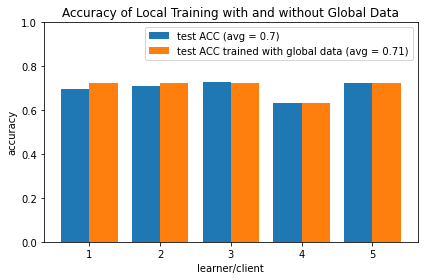

In [92]:
test = [results[l]['test'] for l in results]
testGlobal = [results[l]['test_wGlobal'] for l in results]

testAvg = np.average(np.array(test))
testGlobalAvg = np.average(np.array(testGlobal))

print(testAvg, testGlobalAvg)

x = np.arange(num_learners)

fig, ax = plt.subplots()
width = 0.4

rects1 = ax.bar(x - width/2, test, width, label='test ACC (avg = '+str(round(testAvg,2))+')')
rects2 = ax.bar(x + width/2, testGlobal, width, label='test ACC trained with global data (avg = '+str(round(testGlobalAvg,2))+')')

#ax.hlines(testAvg, 0  - width, num_learners - width, label = 'average test ACC', colors='b', zorder=10)
#ax.hlines(testGlobalAvg, 0  - width, num_learners - width, label = 'average test ACC with global', colors='r', zorder=12)

ax.set_ylabel('accuracy')
ax.set_xlabel('learner/client')
ax.set_title('Accuracy of Local Training with and without Global Data')
ax.set_xticklabels(list(range(num_learners+1)))
ax.set_ylim((0,1))
ax.legend()

fig.tight_layout()
plt.savefig('testAcc.png')
plt.show()